Época: 0/5000	Custo: 1.742E+01
Época: 50/5000	Custo: 4.198E+00
Época: 100/5000	Custo: 2.596E+00
Época: 150/5000	Custo: 4.793E-02
Época: 200/5000	Custo: 1.065E-02
Época: 250/5000	Custo: 8.305E-03
Época: 300/5000	Custo: 6.555E-03
Época: 350/5000	Custo: 5.122E-03
Época: 400/5000	Custo: 3.974E-03
Época: 450/5000	Custo: 3.085E-03
Época: 500/5000	Custo: 2.421E-03
Época: 550/5000	Custo: 1.945E-03
Época: 600/5000	Custo: 1.611E-03
Época: 650/5000	Custo: 1.378E-03
Época: 700/5000	Custo: 1.210E-03
Época: 750/5000	Custo: 1.082E-03
Época: 800/5000	Custo: 9.804E-04
Época: 850/5000	Custo: 8.944E-04
Época: 900/5000	Custo: 8.192E-04
Época: 950/5000	Custo: 7.516E-04
Época: 1000/5000	Custo: 6.901E-04
Época: 1050/5000	Custo: 6.336E-04
Época: 1100/5000	Custo: 5.814E-04
Época: 1150/5000	Custo: 5.331E-04
Época: 1200/5000	Custo: 4.885E-04
Época: 1250/5000	Custo: 4.473E-04
Época: 1300/5000	Custo: 4.094E-04
Época: 1350/5000	Custo: 3.746E-04
Época: 1400/5000	Custo: 3.428E-04
Época: 1450/5000	Custo: 3.137E-04
Épo

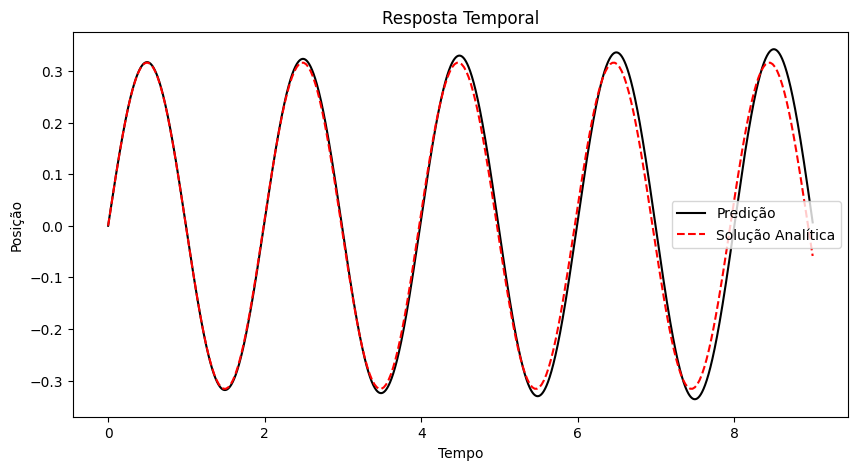

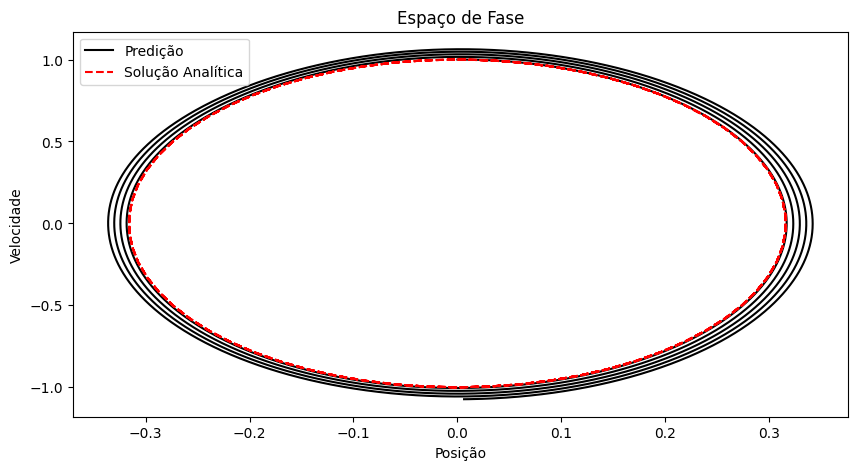

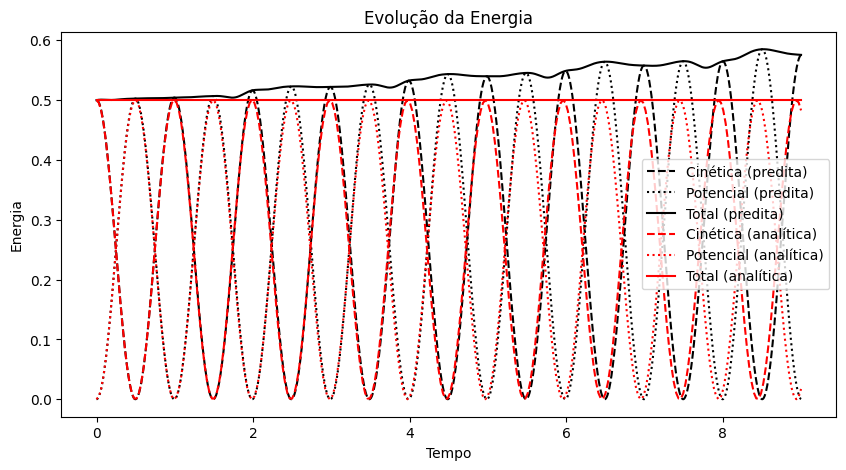

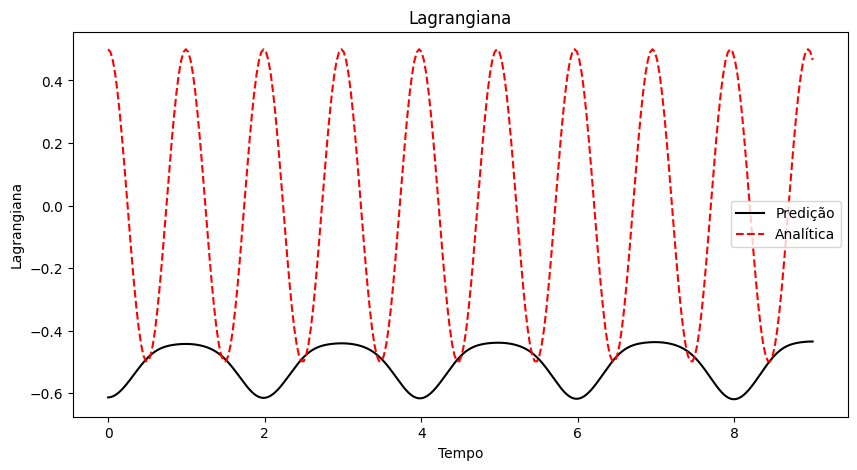

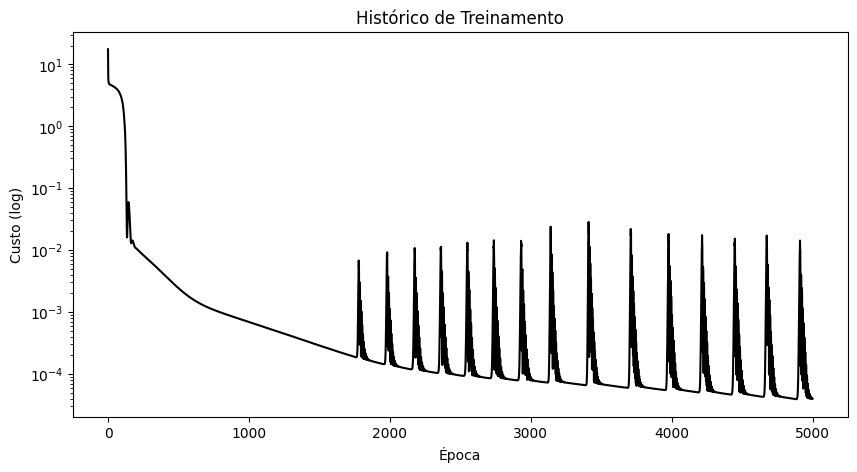

In [4]:
# Importação das bibliotecas necessárias
import torch  # Framework para redes neurais e diferenciação automática
import numpy as np  # Operações numéricas
from torch.autograd import grad  # Para cálculo de derivadas
import matplotlib.pyplot as plt  # Visualização dos resultados

# Configuração da semente para reprodutibilidade
torch.manual_seed(1)

# ==============================================================================
# CONFIGURAÇÕES DO USUÁRIO
# ==============================================================================

# Parâmetros físicos do sistema massa-mola
dx0dt = 1  # Velocidade inicial
k = 10     # Constante da mola
m = 1      # Massa

# Parâmetros de amostragem para treinamento
tmaxTraining = 1.5  # Tempo máximo para dados de treino
numberOfTrainingSamples = 50  # Número de pontos de treino

# Parâmetros de amostragem para validação
tmaxValidation = 9  # Tempo máximo para dados de validação
numberOfValidationSamples = 300  # Número de pontos de validação

# Arquitetura da rede neural
neurons = 50  # Neurônios por camada oculta
layers = 2    # Número de camadas ocultas

# Hiperparâmetros de treinamento
lr = 1e-3    # Taxa de aprendizado
epochs = 5000  # Número de épocas de treinamento

# ==============================================================================
# IMPLEMENTAÇÃO DA REDE NEURAL
# ==============================================================================

class FNN(torch.nn.Module):
    """Feedforward Neural Network para aprendizado da Lagrangiana."""

    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()
        self.layers = layers

        # Definição da arquitetura:
        self.linear1 = torch.nn.Linear(inputSize, neurons)  # Camada de entrada
        self.linear2 = torch.nn.ModuleList()  # Lista de camadas ocultas
        for _ in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)  # Camada de saída
        self.activation = torch.nn.Tanh()  # Função de ativação

    def forward(self, x):
        """Passagem forward da rede."""
        y = self.activation(self.linear1(x))  # Primeira camada
        for i in range(self.layers):  # Camadas ocultas
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)  # Camada de saída (sem ativação)
        return y

# ==============================================================================
# FUNÇÃO PARA CÁLCULO DE DERIVADAS
# ==============================================================================

def getDerivative(y, x, n):
    """
    Calcula a derivada de ordem n de y em relação a x usando autograd.

    Args:
        y: Tensor dependente
        x: Tensor independente
        n: Ordem da derivada

    Returns:
        Tensor com a derivada de ordem n
    """
    if n == 0:
        return y
    else:
        # Calcula derivada primeira
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n-1)  # Recursão para derivadas superiores

# ==============================================================================
# GERAÇÃO DOS DADOS
# ==============================================================================

# Solução analítica do sistema massa-mola
omega = np.sqrt(k/m)  # Frequência natural
A = dx0dt/omega       # Amplitude
phi = 0               # Fase inicial

# Funções para posição, velocidade e aceleração analíticas
x = lambda t: A * np.sin(omega*t + phi)
dxdt = lambda t: omega * A * np.cos(omega*t + phi)
ddxdtt = lambda t: -omega**2 * A * np.sin(omega*t + phi)

# Dados de treinamento (intervalo de tempo menor)
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
trainingData = torch.vstack((
    torch.from_numpy(x(tTraining)),      # Posição (x)
    torch.from_numpy(dxdt(tTraining)),   # Velocidade (dx/dt)
    torch.from_numpy(ddxdtt(tTraining))  # Aceleração (d²x/dt²)
)).to(torch.float32).T

# Dados de validação (intervalo de tempo maior)
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((
    torch.from_numpy(x(tValidation)),
    torch.from_numpy(dxdt(tValidation)),
    torch.from_numpy(ddxdtt(tValidation))
)).to(torch.float32).T

# Preparação da entrada do modelo (posição e velocidade)
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True  # Habilita cálculo de gradientes

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# ==============================================================================
# TREINAMENTO DO MODELO LAGRANGIANO
# ==============================================================================

# Inicialização do modelo e otimizador
model = FNN(2, 1, neurons, layers)  # 2 entradas (x, dx/dt), 1 saída (L)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)  # Histórico do custo

# Loop de treinamento
for epoch in range(epochs):
    optimizer.zero_grad()  # Zera os gradientes

    # 1. Predição da Lagrangiana
    LPred = model(modelInputTraining)

    # 2. Cálculo das derivadas necessárias
    dLPreddx = getDerivative(LPred, modelInputTraining, 1)  # ∇L

    # 3. Cálculo da matriz Hessiana (derivadas segundas)
    Hessian = getDerivative(dLPreddx[:, 0], modelInputTraining, 1)[:, 1]

    # 4. Cálculo da aceleração predita (equação de Euler-Lagrange)
    ddxttPred = (1./dLPreddx[:, 1]) * (dLPreddx[:, 0] - Hessian*modelInputTraining[:, 1])

    # 5. Função custo: erro quadrático na aceleração
    cost = torch.mean((trainingData[:, 2] - ddxttPred)**2)
    costHistory[epoch] = cost.detach()

    # 6. Backpropagation
    cost.backward()
    optimizer.step()

    # Log periódico
    if epoch % 50 == 0:
        print(f"Época: {epoch}/{epochs}\tCusto: {cost.detach():.3E}")

# ==============================================================================
# PÓS-PROCESSAMENTO E VISUALIZAÇÃO
# ==============================================================================

# Configuração da integração numérica
numberOfTimeSteps = 10000  # Número de passos para Euler
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps+1)
dt = tmaxValidation/numberOfTimeSteps  # Tamanho do passo

# Inicialização das variáveis para integração
xPrediction = torch.zeros((2, numberOfTimeSteps+1), requires_grad=False)
xPrediction[:, 0] = validationData[0, :2]  # Condições iniciais

LPredictions = np.zeros(numberOfTimeSteps)  # Para armazenar as predições de L
LLabel = 0.5*m*validationData[:, 1]**2 - 0.5*k*validationData[:, 0]**2  # L analítico

# Integração numérica usando as equações aprendidas
for i in range(numberOfTimeSteps):
    currentx = xPrediction[:, i].unsqueeze(0).detach()
    currentx.requires_grad = True

    # Predição da Lagrangiana e suas derivadas
    LPred = model(currentx)
    LPredictions[i] = LPred[0].detach()
    dLPreddx = getDerivative(LPred, currentx, 1)
    Hessian = getDerivative(dLPreddx[:, 0], currentx, 1)[:, 1]

    # Cálculo da aceleração usando a equação de Euler-Lagrange
    ddxttPred = (1./dLPreddx[:, 1]) * (dLPreddx[:, 0] - Hessian*currentx[:, 1])

    # Método de Euler para integrar as equações
    xPrediction[:, i+1] = (xPrediction[:, i] + dt * torch.tensor([
        currentx[0, 1],  # dx/dt = v
        ddxttPred[0]     # dv/dt = a (calculada acima)
    ])).detach()

# Visualização dos resultados --------------------------------------------------

# 1. Resposta temporal
plt.figure(figsize=(10,5))
plt.plot(tPrediction, xPrediction[0, :], 'k', label="Predição")
plt.plot(tValidation, validationData[:, 0], 'r--', label="Solução Analítica")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.title("Resposta Temporal")
plt.show()

# 2. Espaço de fase (posição x velocidade)
plt.figure(figsize=(10,5))
plt.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Predição")
plt.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Solução Analítica")
plt.xlabel("Posição")
plt.ylabel("Velocidade")
plt.legend()
plt.title("Espaço de Fase")
plt.show()

# 3. Evolução da energia
plt.figure(figsize=(10,5))
# Energias preditas
plt.plot(tPrediction, 0.5/m*xPrediction[1, :]**2, 'k--', label="Cinética (predita)")
plt.plot(tPrediction, 0.5*k*xPrediction[0, :]**2, 'k:', label="Potencial (predita)")
plt.plot(tPrediction, 0.5/m*xPrediction[1, :]**2 + 0.5*k*xPrediction[0, :]**2, 'k', label="Total (predita)")

# Energias analíticas
plt.plot(tValidation, 0.5/m*validationData[:, 1]**2, 'r--', label="Cinética (analítica)")
plt.plot(tValidation, 0.5*k*validationData[:, 0]**2, 'r:', label="Potencial (analítica)")
plt.plot(tValidation, 0.5/m*validationData[:, 1]**2 + 0.5*k*validationData[:, 0]**2, 'r', label="Total (analítica)")

plt.xlabel("Tempo")
plt.ylabel("Energia")
plt.legend()
plt.title("Evolução da Energia")
plt.show()

# 4. Comparação da Lagrangiana predita com a analítica
plt.figure(figsize=(10,5))
plt.plot(tPrediction[:-1], LPredictions, 'k', label="Predição")
plt.plot(tValidation, LLabel, 'r--', label="Analítica")
plt.xlabel("Tempo")
plt.ylabel("Lagrangiana")
plt.legend()
plt.title("Lagrangiana")
plt.show()

# 5. Histórico de treinamento (evolução da função custo)
plt.figure(figsize=(10,5))
plt.plot(costHistory, 'k')
plt.yscale('log')
plt.xlabel("Época")
plt.ylabel("Custo (log)")
plt.title("Histórico de Treinamento")
plt.show()